# Обработка данных

In [1]:
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from matplotlib import cm
from random import randint
from typing import Optional
from sklearn.model_selection import train_test_split

import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchmetrics import JaccardIndex

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATADIR = 'DATASET/'

In [2]:
def image_rz(img):
  height = img.shape[0]
  width = img.shape[1]
  problem = abs(height - width)
  sz = [int(problem / 2), problem - int(problem / 2), 0]
  if width >= height:
    img = cv2.copyMakeBorder(img, sz[0], sz[1], sz[2],
                            sz[2], cv2.BORDER_CONSTANT)
  else:
    img = cv2.copyMakeBorder(img, sz[2], sz[2], sz[0],
                            sz[1], cv2.BORDER_CONSTANT)
  img = cv2.resize(img, (224, 224))
  return img

In [3]:
def get_data(images_path, masks_path):
    file_names = os.listdir(images_path)
    images = []
    for fname in sorted(file_names):
      image_path = os.path.join(images_path, fname)
      image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
      image = image_rz(image)
      images += [image]

    file_names = os.listdir(masks_path)
    masks = []
    for fname in sorted(file_names):
      mask_path = os.path.join(masks_path, fname)
      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
      mask = image_rz(mask)
      masks += [mask]
    return images, masks

In [4]:
gen_bad_images, gen_bad_masks = get_data(DATADIR + 'gen_smoke_bad/', DATADIR + 'gen_smoke_bad_masks/')
orig_images, orig_masks = get_data(DATADIR + 'orig_smoke/', DATADIR + 'orig_smoke_masks/')

# Деление данных на наборы обучения

In [5]:
train_orig_im, test_orig_im, train_orig_mk, test_orig_mk = train_test_split(orig_images, orig_masks, test_size = 0.20)
train_gen_bad_im, test_gen_bad_im, train_gen_bad_mk, test_gen_bad_mk = train_test_split(gen_bad_images, gen_bad_masks, test_size = 0.20)

In [6]:
class SmokeDataset(Dataset):
    
    def __init__(self, images, masks, transforms):
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        mask = self.masks[index]
        image = self.transforms(image)
        
        return image, mask

In [7]:
train_batch_size=4
test_batch_size=4
transform=transforms.Compose([transforms.ToTensor()])

transform_no_gauss=transforms.Compose([transforms.ToTensor()])

train_orig_set = SmokeDataset(train_orig_im, train_orig_mk, transform_no_gauss)
test_orig_set = SmokeDataset(test_orig_im, test_orig_mk, transform_no_gauss)
train_gen_bad_set = SmokeDataset(train_gen_bad_im, train_gen_bad_mk, transform)
test_gen_bad_set = SmokeDataset(test_gen_bad_im, test_gen_bad_mk, transform)

train_orig_loader = DataLoader(train_orig_set, train_batch_size, shuffle=True)
test_orig_loader = DataLoader(test_orig_set, test_batch_size)
train_gen_bad_loader = DataLoader(train_gen_bad_set, train_batch_size, shuffle=True)
test_gen_bad_loader = DataLoader(test_gen_bad_set, test_batch_size)

In [8]:
def get_mean_std(train_loader):
    mean = torch.tensor([0., 0., 0.])
    std = torch.tensor([0., 0., 0.])
    for data in train_loader:
      img, mask = data
      mean += img.mean([0, 2, 3])
      std += img.std([0, 2, 3]) 
    mean /= len(train_loader)
    std /= len(train_loader)
    return mean, std

In [9]:
train_batch_size=4
test_batch_size=4
mean_orig, std_orig = get_mean_std(train_orig_loader)
mean_gen_bad, std_gen_bad = get_mean_std(train_gen_bad_loader)
transform_gen_bad=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(mean_gen_bad, std_gen_bad),
                              transforms.GaussianBlur(kernel_size=(7, 13), sigma=(0.25, 0.5))])

transform_orig=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(mean_orig, std_orig)])

train_orig_set = SmokeDataset(train_orig_im, train_orig_mk, transform_orig)
test_orig_set = SmokeDataset(test_orig_im, test_orig_mk, transform_orig)
train_gen_bad_set = SmokeDataset(train_gen_bad_im, train_gen_bad_mk, transform_gen_bad)
test_gen_bad_set = SmokeDataset(test_gen_bad_im, test_gen_bad_mk, transform_gen_bad)

train_orig_loader = DataLoader(train_orig_set, train_batch_size, shuffle=True)
test_orig_loader = DataLoader(test_orig_set, test_batch_size)
train_gen_bad_loader = DataLoader(train_gen_bad_set, train_batch_size, shuffle=True)
test_gen_bad_loader = DataLoader(test_gen_bad_set, test_batch_size)

In [10]:
model = smp.Unet(
    encoder_name = "senet154",
    encoder_depth = 5,
    encoder_weights = 'imagenet',
    activation = 'sigmoid'
)
model.to(device)
# for name, param in model.named_parameters():
#     if 'encoder' in name:
#         param.requires_grad = False

Unet(
  (encoder): SENetEncoder(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu3): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEBottleneck(
        (conv1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.

# Обучение

In [11]:
EPOCH = 1

In [12]:
def show_loss(train_loss):
    fig=plt.figure(figsize=(10, 7))
    plt.plot(np.arange(1, len(train_loss)+1), train_loss, label="Train loss")
    plt.xlabel('Loss')
    plt.ylabel('Epochs')
    plt.title("Loss Plots")
    plt.legend(loc='upper right')
    plt.show()

In [13]:
def iou(realMask, resultMask):
  acc = 0.0
  for mask_orig, mask in zip(realMask, resultMask):
    m = JaccardIndex(num_classes=2)
    m = m.to(device)
    acc += m(mask_orig, mask)
  return acc

In [14]:
def train(model, loss_fn, train_loader, test_loader, learning_rate=1e-4, num_epoch=20):
    best_EPOCH = 0
    best_EPOCH_ind = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss = []
    test_loss = []
    
    for epoch in range(num_epoch):
        global EPOCH
        model.train()
        epoch_loss = 0
        if (epoch + 1) % 5 == 0:
            learning_rate /= 5
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            images, masks_orig = data
            images = images.to(device)
            masks_orig = masks_orig.to(device)
            masks = model(images)
            masks = masks.squeeze(1)
            masks_orig = masks_orig.float()/255.0
            loss = loss_fn(masks, masks_orig)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

        epoch_loss = epoch_loss/(i+1)
        train_loss.append(epoch_loss) 
        print("Epoch: {} Train Loss: {:.4}".format(EPOCH, epoch_loss))

        model.eval()
        acc = 0
        for i, data in enumerate(test_loader):
            images, masks_orig = data
            images = images.to(device)
            masks_orig = masks_orig.to(device) > 128
            masks = model(images)
            masks = masks.squeeze(1)
            masks = (masks.round()).int()
            acc_batch = iou(masks_orig, masks)
            acc += acc_batch/len(images)
            
        acc = acc/(i+1)
        
        if best_EPOCH < acc:
            best_EPOCH = acc
            best_EPOCH_ind = EPOCH
        
        test_loss.append(acc.to('cpu'))
        print("Epoch: {} Test Acc: {:.4}\n".format(EPOCH, acc))
        torch.save(model.state_dict(), "EPOCH/model_weights-" + str(EPOCH) + ".pth")
        EPOCH += 1
        
    show_loss(train_loss)
    show_loss(test_loss)
    model.load_state_dict(torch.load("EPOCH/model_weights-" + str(best_EPOCH_ind) + ".pth", map_location=torch.device(device)))
    return acc

MIOpen(HIP): Warning [SQLiteBase] Missing system database file: gfx1030_20.kdb Performance may degrade. Please follow instructions to install: https://github.com/ROCmSoftwarePlatform/MIOpen#installing-miopen-kernels-package


Epoch: 1 Train Loss: 0.1371
Epoch: 1 Test Acc: 0.9733

Epoch: 2 Train Loss: 0.03574
Epoch: 2 Test Acc: 0.9785

Epoch: 3 Train Loss: 0.03118
Epoch: 3 Test Acc: 0.9796

Epoch: 4 Train Loss: 0.0213
Epoch: 4 Test Acc: 0.9808

Epoch: 5 Train Loss: 0.01927
Epoch: 5 Test Acc: 0.9812



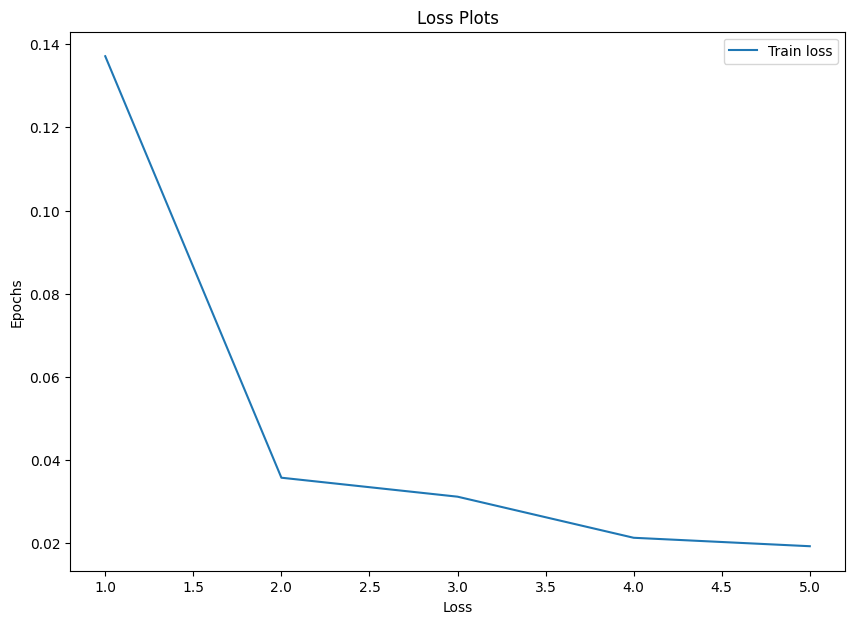

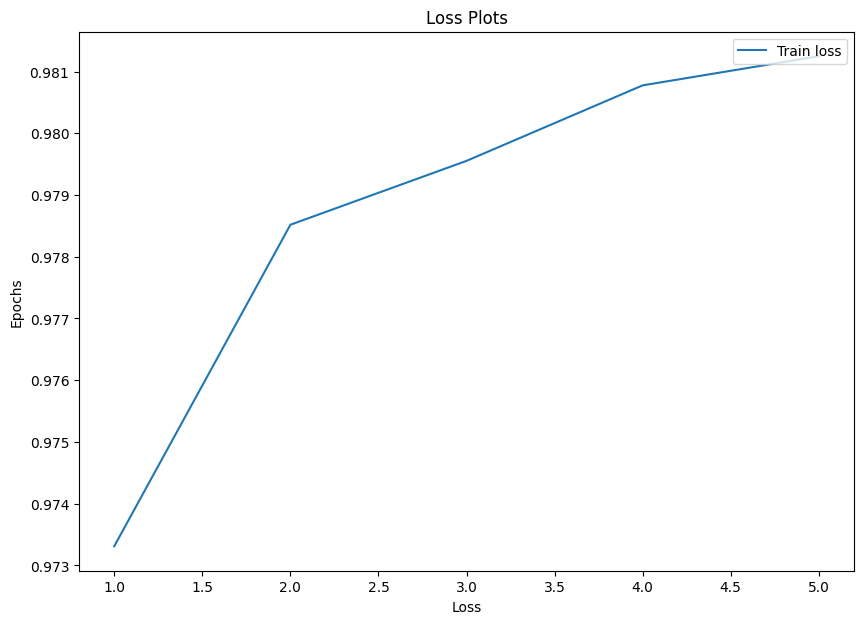

tensor(0.9812, device='cuda:0')

In [15]:
loss_fn = torch.nn.BCELoss()
train(model, loss_fn, train_gen_bad_loader, test_gen_bad_loader, num_epoch=5)

Epoch: 6 Train Loss: 0.3397
Epoch: 6 Test Acc: 0.6915

Epoch: 7 Train Loss: 0.1614
Epoch: 7 Test Acc: 0.7695

Epoch: 8 Train Loss: 0.1114
Epoch: 8 Test Acc: 0.7799

Epoch: 9 Train Loss: 0.08943
Epoch: 9 Test Acc: 0.8035

Epoch: 10 Train Loss: 0.07349
Epoch: 10 Test Acc: 0.7936

Epoch: 11 Train Loss: 0.06209
Epoch: 11 Test Acc: 0.8108

Epoch: 12 Train Loss: 0.05677
Epoch: 12 Test Acc: 0.8145

Epoch: 13 Train Loss: 0.04708
Epoch: 13 Test Acc: 0.8199

Epoch: 14 Train Loss: 0.04416
Epoch: 14 Test Acc: 0.8262

Epoch: 15 Train Loss: 0.04006
Epoch: 15 Test Acc: 0.8274

Epoch: 16 Train Loss: 0.03776
Epoch: 16 Test Acc: 0.8315

Epoch: 17 Train Loss: 0.03452
Epoch: 17 Test Acc: 0.8323

Epoch: 18 Train Loss: 0.033
Epoch: 18 Test Acc: 0.8314

Epoch: 19 Train Loss: 0.03143
Epoch: 19 Test Acc: 0.8361

Epoch: 20 Train Loss: 0.03194
Epoch: 20 Test Acc: 0.834



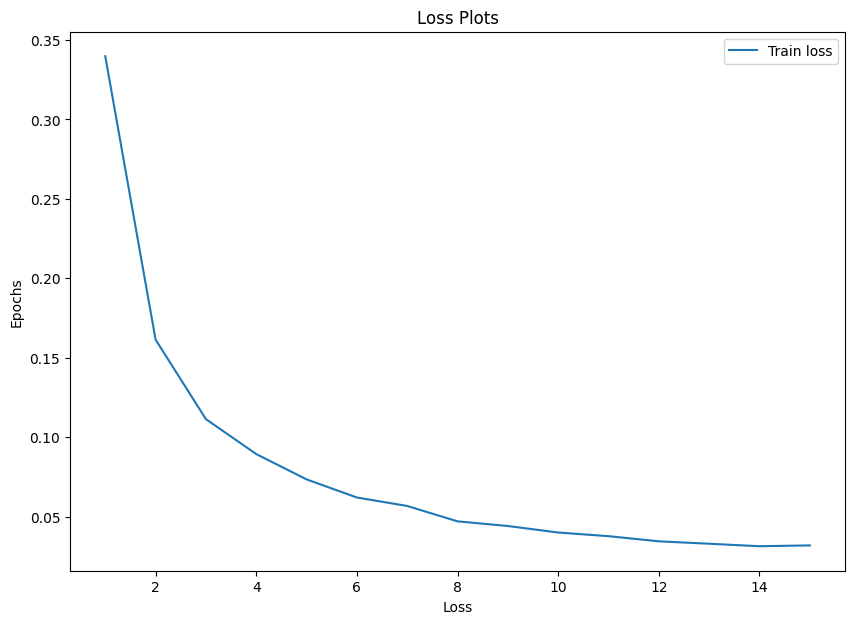

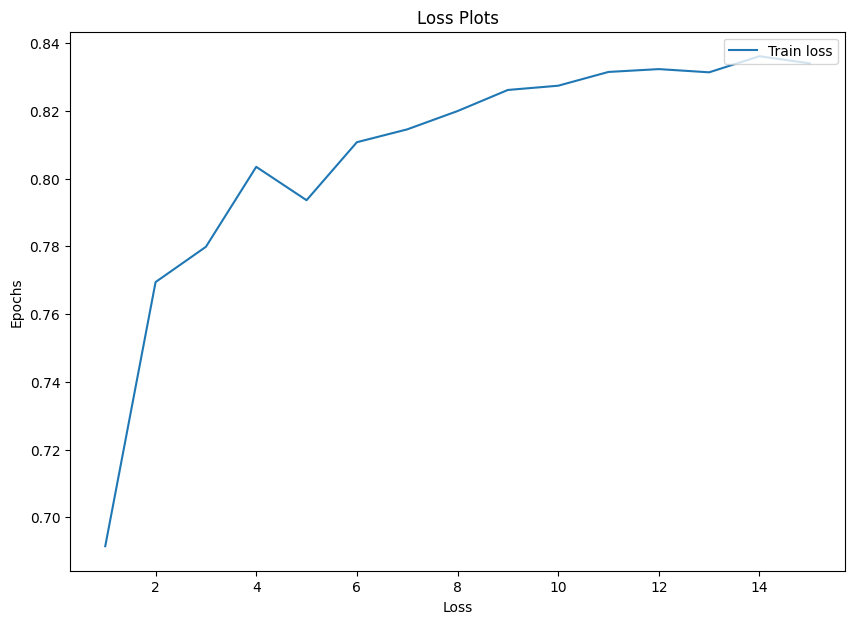

tensor(0.8340, device='cuda:0')

In [16]:
train(model, loss_fn, train_orig_loader, test_orig_loader, num_epoch=15)

# Тест нейронки

In [17]:
class SmokeDatasetTest(Dataset):
    
    def __init__(self, images, transforms):
        self.images = images
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        image_orig = self.images[index]
        image = self.transforms(image)
        
        return image, image_orig

In [18]:
images_test_path = DATADIR + 'test/'

file_test_names = os.listdir(images_test_path)
images1 = []
for fname in sorted(file_test_names):
  image_path = os.path.join(images_test_path, fname)
  image = cv2.imread(image_path)
  image = image_rz(image)
  images1 += [image]
 
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(mean_orig, std_orig)])

test1_set = SmokeDatasetTest(images1, transform)
test1_loader = DataLoader(test1_set, 1)

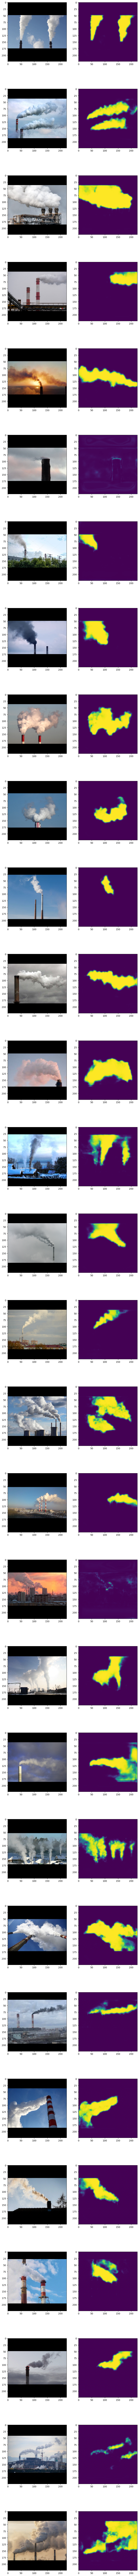

In [19]:
fig, ax = plt.subplots(len(file_test_names), 2, figsize=(10, 200))
with torch.no_grad():
    model.eval()
    for i, data in enumerate(test1_loader):
        img, img_orig = data
        mask = model(img.to(device))
        ax[i][0].imshow(cv2.cvtColor(img_orig[0].numpy(), cv2.COLOR_BGR2RGB))
        
        msk = mask[0].permute(1, 2, 0).cpu().numpy()
        ax[i][1].imshow(msk)
fig.savefig("result.jpg")

In [20]:
# torch.save(model.state_dict(), "BEST model/19.09.pth")